In [41]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Loading

In [60]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    samplewise_center=True,
    samplewise_std_normalization=True)

train_ds = image_generator.flow_from_directory(
    directory='DATA/train/',
    classes=['normal', 'covid'],
    class_mode='binary',
    subset='training',
    batch_size=32,
    target_size=(256, 256),
    seed=42,
    shuffle=True,)

validation_ds = image_generator.flow_from_directory(
    directory='DATA/train/',
    class_mode='binary',
    classes=['normal', 'covid'],
    subset='validation',
    batch_size=32,
    target_size=(256, 256),
    seed=42,
    shuffle=True,)

test_ds = image_generator.flow_from_directory(
    directory='DATA/test/',
    class_mode='binary',
    classes=['normal', 'covid'],
    batch_size=32,
    shuffle=True,
    target_size=(256, 256),
    seed=42,)


Found 2024 images belonging to 2 classes.
Found 867 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [62]:
IMAGE_SIZE = [256, 256]
CLASS_NAMES = ["normal", "covid"]
train_paths = 'DATA/train/'

COUNT_NORMAL = len([filename for filename in os.listdir(train_paths+'normal/')])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_COVID = len([filename for filename in os.listdir(train_paths+'covid/')])
print("Covid images count in training set: " + str(COUNT_COVID))

Normal images count in training set: 1201
Covid images count in training set: 1690


# Densenet Finetuning

In [63]:
# Create the base pre-trained model
base_model = DenseNet121(weights='./models/nih/densenet.hdf5', include_top=False);

In [65]:
x = base_model.output
# Add a global spatial average pooling layer
x_pool = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x_pool)

In [66]:
# Create an updated model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, None, None,   0          ['input_5[0][0]']                
 D)                             3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d_8[0][0]']       
                                64)                                                         

                                                                                                  
 conv2_block3_concat (Concatena  (None, None, None,   0          ['conv2_block2_concat[0][0]',    
 te)                            160)                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, None, None,   640        ['conv2_block3_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv2_block4_0_relu (Activatio  (None, None, None,   0          ['conv2_block4_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, None, None,   16384       ['conv3_block1_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv3_block5_1_conv (Conv2D)   (None, None, None,   32768       ['conv3_block5_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block5_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, None, None,   0          ['conv3_block5_1_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block9_0_relu (Activatio  (None, None, None,   0          ['conv3_block9_0_bn[0][0]']      
 n)                             384)                                                              
                                                                                                  
 conv3_block9_1_conv (Conv2D)   (None, None, None,   49152       ['conv3_block9_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block9_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block9_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_blo

                                512)                                                              
                                                                                                  
 pool3_relu (Activation)        (None, None, None,   0           ['pool3_bn[0][0]']               
                                512)                                                              
                                                                                                  
 pool3_conv (Conv2D)            (None, None, None,   131072      ['pool3_relu[0][0]']             
                                256)                                                              
                                                                                                  
 pool3_pool (AveragePooling2D)  (None, None, None,   0           ['pool3_conv[0][0]']             
                                256)                                                              
          

 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, None, None,   0          ['conv4_block4_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_block4_concat (Concatena  (None, None, None,   0          ['conv4_block3_concat[0][0]',    
 te)      

                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block8_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, None, None,   0          ['conv4_block8_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv4_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv4_blo

                                128)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block12_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block12_1_relu[0][0]']   
                                32)                                                               
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block16_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, None, None,   110592      ['conv4_block20_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block20_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block20_1_relu (Activati  (None, None, None,   0          ['conv4_block20_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv4_blo

 on)                            992)                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, None, None,   126976      ['conv4_block24_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, None, None,   512        ['conv4_block24_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv4_block24_1_relu (Activati  (None, None, None,   0          ['conv4_block24_1_bn[0][0]']     
 on)                            128)                                                              
          

 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block3_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block3_concat (Concatena  (None, None, None,   0          ['conv5_block2_concat[0][0]',    
 te)                            608)                              'conv5_block3_2_conv[0][0]']    
                                                                                                  
 conv5_block4_0_bn (BatchNormal  (None, None, None,   2432       ['conv5_block3_concat[0][0]']    
 ization) 

                                                                                                  
 conv5_block7_1_relu (Activatio  (None, None, None,   0          ['conv5_block7_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv5_block7_2_conv (Conv2D)   (None, None, None,   36864       ['conv5_block7_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv5_block7_concat (Concatena  (None, None, None,   0          ['conv5_block6_concat[0][0]',    
 te)                            736)                              'conv5_block7_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 lization)                      128)                                                              
                                                                                                  
 conv5_block11_1_relu (Activati  (None, None, None,   0          ['conv5_block11_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block11_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block11_concat (Concaten  (None, None, None,   0          ['conv5_block10_concat[0][0]',   
 ate)                           864)                              'conv5_block11_2_conv[0][0]']   
          

 conv5_block15_1_bn (BatchNorma  (None, None, None,   512        ['conv5_block15_1_conv[0][0]']   
 lization)                      128)                                                              
                                                                                                  
 conv5_block15_1_relu (Activati  (None, None, None,   0          ['conv5_block15_1_bn[0][0]']     
 on)                            128)                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block15_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block15_concat (Concaten  (None, None, None,   0          ['conv5_block14_concat[0][0]',   
 ate)     

In [67]:
initial_bias = np.log([COUNT_COVID / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_COVID
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_COVID) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 0.34157
Weight for class 0: 1.20
Weight for class 1: 0.86


In [68]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [70]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],)

Epoch 1/10
64/64 [==============================] - 1564s 24s/step - loss: 0.5063 - binary_accuracy: 0.7989 - precision: 0.8633 - recall: 0.7794 - val_loss: 5103365390336.0000 - val_binary_accuracy: 0.5848 - val_precision: 0.5848 - val_recall: 1.0000
Epoch 2/10
64/64 [==============================] - 1681s 26s/step - loss: 0.3142 - binary_accuracy: 0.8750 - precision: 0.9306 - recall: 0.8495 - val_loss: 269313.0625 - val_binary_accuracy: 0.5848 - val_precision: 0.5848 - val_recall: 1.0000
Epoch 3/10
64/64 [==============================] - 1622s 25s/step - loss: 0.2426 - binary_accuracy: 0.8987 - precision: 0.9429 - recall: 0.8800 - val_loss: 338.5883 - val_binary_accuracy: 0.5848 - val_precision: 0.5848 - val_recall: 1.0000
Epoch 4/10
64/64 [==============================] - 1590s 25s/step - loss: 0.1949 - binary_accuracy: 0.9308 - precision: 0.9563 - recall: 0.9239 - val_loss: 141.5746 - val_binary_accuracy: 0.5848 - val_precision: 0.5848 - val_recall: 1.0000
Epoch 5/10
64/64 [=====

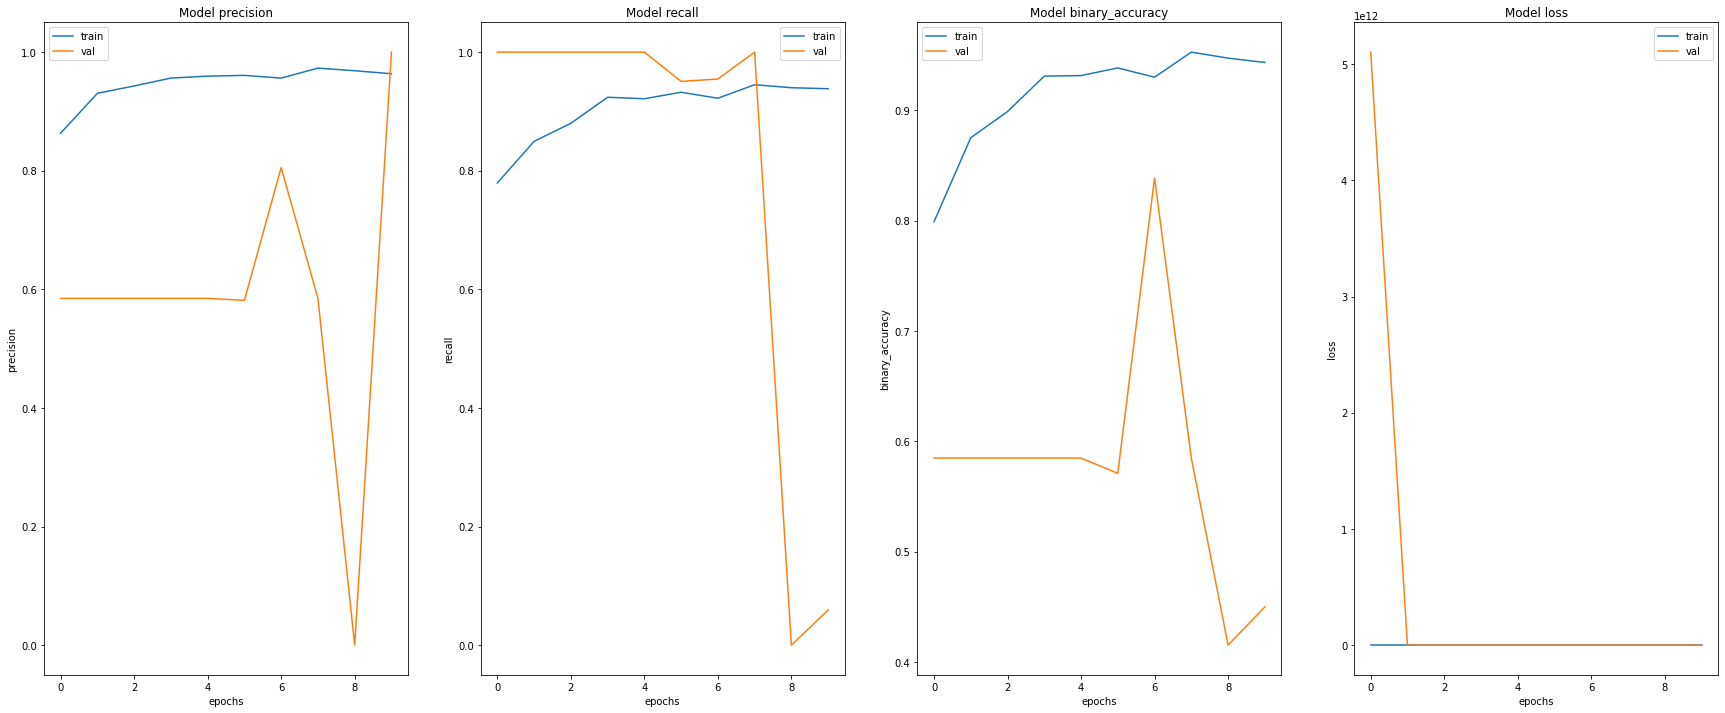

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(30, 12))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [74]:
best_model = keras.models.load_model('xray_model.h5')

In [75]:
best_model.evaluate(test_ds)

7/7 [==============================] - 38s 5s/step - loss: 0.9722 - binary_accuracy: 0.8600 - precision: 0.8000 - recall: 0.9600


[0.9721701145172119, 0.8600000143051147, 0.800000011920929, 0.9599999785423279]

In [76]:
best_model.evaluate(validation_ds)

28/28 [==============================] - 172s 6s/step - loss: 0.7264 - binary_accuracy: 0.8385 - precision: 0.8053 - recall: 0.9546


[0.7264050245285034,
 0.8385236263275146,
 0.8053244352340698,
 0.9546350836753845]